We are going to create a text dataset from the books of [P. G. Wodehouse](https://en.wikipedia.org/wiki/P._G._Wodehouse) for language modelling.
I enjoy his style of writing, and his books are in the public domain in many countries, so it's a fun dataset to train language models on.

Here we will download his books from Project Gutenberg, do some light exploratory analysis and data cleaning, and save the dataset for future language modelling.

::: {.callout-note}
This is a Jupyter notebook you can [download](https://github.com/EdwardJRoss/skeptric/blob/master/wodehouse/index.ipynb) 
:::

In [1]:
#| echo: false

import matplotlib.pyplot as plt
import numpy as np

# Load the Data

We'll download all the books written by P. G. Wodehouse from Project Gutenberg following my guide to [downloading from Project Gutenberg](https://skeptric.com/gutenberg/).
Firstly we only want to download things once when iterating with this code, so I'll create a Python [shelve](https://docs.python.org/3/library/shelve.html) to store the downloaded data.

In [2]:
from pathlib import Path
import shelve

data_path = Path('./data/')
data_path.mkdir(exist_ok=True)

wodehouse_books = shelve.open(data_path / 'wodehouse.shelve')

len(wodehouse_books)

48

Then we search the index to find all P.G Wodehouse texts (excluding indexes).

In [3]:
import csv
from io import StringIO
import requests

if not wodehouse_books:
    GUTENBERG_CSV_URL = "https://www.gutenberg.org/cache/epub/feeds/pg_catalog.csv.gz"
    
    r = requests.get(GUTENBERG_CSV_URL)
    csv_text = r.content.decode("utf-8")
    
    for b in csv.DictReader(StringIO(csv_text)):
        if "Wodehouse, P. G." in b["Authors"] \
            and "Indexes" not in b["Subjects"] \
            and b["Type"] == "Text":
            wodehouse_books[b["Text#"]] = b
    
    len(wodehouse_books)

And we download the text; we make a slight deviation here in using the txt files rather than the zip files.
(Text# 70222 (Meet Mr Mulliner) is [only available as a txt](http://aleph.gutenberg.org/7/0/2/2/70222/)).

In [4]:
def gutenberg_text_urls(id: str,
                        mirror="http://aleph.gutenberg.org",
                        suffixes=("", "-8", "-0")) -> list[str]:
    path = "/".join(id[:-1]) or "0"
    return [f"{mirror}/{path}/{id}/{id}{suffix}.txt" for suffix in suffixes]

def download_gutenberg(id: str) -> str:
    for url in gutenberg_text_urls(id):
        r = requests.get(url)
        if r.status_code == 404:
            # Try the next possible URL
            continue
        r.raise_for_status()
        break
    else:
        raise Exception("Unable to download %s" % id)

    return r.content.decode('utf-8')

for book_id, book in wodehouse_books.items():
    if "raw_text" not in book:
        # Note: Assign the object for shelve
        wodehouse_books[book_id] = book | dict(raw_text=download_gutenberg(book_id))

In [5]:
wodehouse_books.close()

# Looking at the Data

Let's have a look at our corpus of P. G. Wodehouse books and clean them up a little.

First let's load the data from our shelf into a dictionary, and store the individual book ids and raw text:

In [6]:
shelf = shelve.open(data_path / 'wodehouse.shelve')
wodehouse_books = {k:v for k,v in shelf.items()}
shelf.close()

book_ids = list(wodehouse_books.keys())
raw_texts = [book['raw_text'] for book in wodehouse_books.values()]

len(wodehouse_books)

48

We can look at a small section of text to get an idea of the writing style.

In [7]:
print(raw_texts[13][14_500:15_000])

he is, I'll bet he doesn't
show it. He's not like Blackburn. I wish he was. Here he comes, so
perhaps we'd better talk about something else."

The vanguard of the boys returning from preparation had passed them,
and they were now standing at the gate of the house. As Fenn spoke, a
little, restless-looking man in cap and gown came up. His clean-shaven
face wore an expression of extreme alertness--the sort of look a ferret
wears as he slips in at the mouth of a rabbit-hole. A doctor, calle


The Project Gutenberg metadata contains the titles for each of the books.

If we compare with [P. G. Wodehouse's Bibliography](https://en.wikipedia.org/wiki/P._G._Wodehouse_bibliography) we can see a lot of texts are missing from Project Gutenberg, and that we have a mixture of Short Stories and Novels.
Considerably more are available [on archive.org](https://archive.org/search?query=wodehouse&and%5B%5D=lending%3A%22is_readable%22&and%5B%5D=mediatype%3A%22texts%22) but their text is low-quality OCR and so requires better transcription (a fun project for another day).

In [8]:
import re

def fmtcols(items: list[str], n_cols: int, max_len: int=40, buffer: int=5):
    """Formats a list of strings into a table with n_cols columns

      items:   The strings to format
      ncols:   The number of columns per line
      max_len: The length of each field
      buffer:  Space from end of text to the end of each field
    """
    items_truncated = [item if len(item) < (max_len - buffer) 
                       else item[:max_len-buffer-3] + "..."
                       for item in items]
    format_str = "{:<" + str(max_len) + "}"
    lines = (
        (format_str * len(items[i:i+n_cols]))
        .format(*items_truncated[i:i+n_cols])
             for i in range(0,len(items),n_cols))
    return '\n'.join(lines)

book_titles = sorted([re.sub('\s+', ' ', book["Title"])
                      for book in wodehouse_books.values()],
                     key=lambda x: re.sub("^(A |The )", "", x))

print(fmtcols(book_titles, 3, max_len=30, buffer=3))

The Adventures of Sally       Carry On, Jeeves              The Clicking of Cuthbert      
The Coming of Bill            A Damsel in Distress          Death at the Excelsior, ...   
Divots                        The Gem Collector             A Gentleman of Leisure        
The Girl on the Boat          The Gold Bat                  The Head of Kay's             
Indiscretions of Archie       The Inimitable Jeeves         The Intrusion of Jimmy        
Jill the Reckless             Leave it to Psmith            The Little Nugget             
The Little Warrior            Love Among the Chickens       Love Among the Chickens ...   
The Man Upstairs and Oth...   A Man of Means                The Man with Two Left Fe...   
Meet Mr Mulliner              Mike                          Mike and Psmith               
My Man Jeeves                 Not George Washington — ...   Piccadilly Jim                
The Politeness of Prince...   The Pothunters                A Prefect's Uncle             

# Removing footers and headers


If we have a look at the start of any of the books there is a header inserted by Project Gutenberg before the main text starts.
We can copy the [method of gutenbergr](https://github.com/ropensci/gutenbergr/blob/96cf4f5d06b3106d32f6720ac32172540f4cd65f/R/gutenberg_download.R#L186-L228) for cleaning the text.

Here's my non-vectorised regular expression based version for finding the header:

In [9]:
import re

HEADER_RE = re.compile("""
(?:                                  # Find the end of the header
  ^\\*\\*\\*.*PROJECT\ GUTENBERG|     
  END.*SMALL\ PRINT                   
)
.*                                  # Until the end of the line
[\r\n]+                             # And some number of blank lines
(?:                                   # Search for informational paragraphs
  (?i:                                # Their first line contains:
    .*Produced\ by
    |.*prepared\ by
    |.*transcribed\ from
    |.*project\ gutenberg
    |special\ thanks
    |note:\ 
    |\\[?transcriber[’']s\ note           # Not from Gutenbergr
    |for\ this\ text\ version             # but useful here
  )
  (?:[^\r\n]*[\r]?[\n])               # Until the end of the line
  (?:[^\r\n]+[\r]?[\n])*              # Until the end of the paragraph
  [\r\n]+                             # And all newlines beneath it  
)*                                  # Repeatedly 
""", 
flags=re.MULTILINE | re.VERBOSE)

print(HEADER_RE.search(raw_texts[2]).group())

*** START OF THIS PROJECT GUTENBERG EBOOK A DAMSEL IN DISTRESS ***




Produced by Jim Tinsley











[Transcriber's Note for edition 11: in para. 4 of Chapter 19, the
word "leafy" has been changed to "leaky". "leafy" was the word used
in the printed edition, but was an obvious misprint. Some readers
have noted that other editions have slightly different punctuation,
notably some extra commas, and semi-colons where there are colons in
this edition; but the punctuation herein does follow at least one
printed text.--jt]









As a sanity check all all the headers are below about 1000 characters:

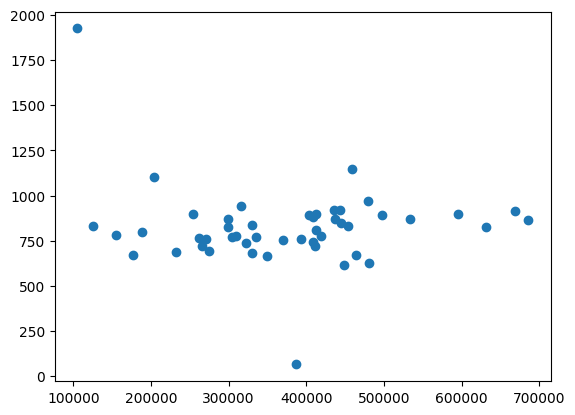

In [10]:
lengths = [HEADER_RE.search(text).end() for text in raw_texts]
text_lengths = [len(text) for text in raw_texts]
plt.scatter(text_lengths, lengths);

The shortest one just doesn't have much information before the text:

In [11]:
min_idx = lengths.index(min(lengths))

print(raw_texts[min_idx][:200])

﻿
*** START OF THE PROJECT GUTENBERG EBOOK DIVOTS ***





                                DIVOTS

                            P. G. WODEHOUSE




                          By P. G. WODE


We can build a much simpler expression for the footer:

In [12]:
FOOTER_RE = "(?:End of .*Project Gutenberg.*|\\*\\*\\*.*END OF.*PROJECT GUTENBERG)"

But we can also extend it to remove transcriber's notes and THE END.

In [13]:
FOOTER_RE = re.compile("""
(
[\r\n]+                                 # Newlines
(?:
  \s*
  (?:
      THE\ END
    | [+|]?-{5,}[|+]?
   )
   \s*
  [\r\n]+                               # Newlines
)?                                  # Optional
(?:                                   # Additional data before footer
  (?i:                                # Lines starting with:
    \s*[\\[|]?transcriber[’']s\ note       
   )
  (?:[^\r\n]*)[\r]?[\n]{,1}           # Until the end of the line
  ((?:[\r]?[\n]){1,2}[^\r\n]+)*       # Until the end of the paragraph
                                      # (allowing 1 space)
  [\r\n]+                             # And all newlines beneath it  
)*
(?:
  End\ of\ .*Project\ Gutenberg.*
  |\\*\\*\\*.*END\ OF.*PROJECT\ GUTENBERG
)
)
""",
flags=re.MULTILINE | re.VERBOSE)

print(FOOTER_RE.search(raw_texts[12]).group())



THE END



Transcriber’s Note: While I left several variant spellings such as
vodevil and bethrothed, I did correct the following:

Fixed: course/coarse in
Yet somehow this course, rough person in front of him never seemed to
allow him a word

Fixed: awfuly/awfully in:
He’s awfuly good to girls who’ve worked in shows for him before.

Fixed: Pullfan/Pullman
Those Pullfan porters on parade!”

Fixed: a large typo in the print edition, which originally read:
“Yes. I’ve got the most damned attack of indigestion.” Derek should
recline in the arm-chair which he had vacated; dinner!”




*** END OF THE PROJECT GUTENBERG


The footers all tend to be around 20000 characters:

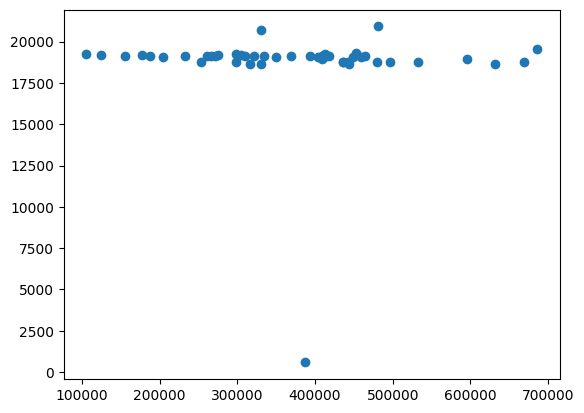

In [14]:
lengths = [len(text) - FOOTER_RE.search(text).start() for text in raw_texts]
text_lengths = [len(text) for text in raw_texts]
plt.scatter(text_lengths, lengths);

Here's the start of a typical footer:

In [15]:
max_idx = lengths.index(max(lengths))

print(raw_texts[max_idx][-lengths[max_idx]:-lengths[max_idx]+500])









--------------------------------

Transcriber's Notes for edition 11:

I am greatly indebted to the Wodehouse readers from the BLANDINGS
e-mail group who did such detailed research on this text, not only
on simple typos but on the differences between the 1916 Saturday
Evening Post serialization and the US and UK early printings.

I have made use, in this new PG edition, of the 1918 UK first edition
references provided by these helpful savants, to correct misprints or
o


The shortest one doesn't have the usual notices at the end

In [16]:
min_idx = lengths.index(min(lengths))

print(raw_texts[min_idx][-100:])

to far over” changed to “much too far over”



*** END OF THE PROJECT GUTENBERG EBOOK DIVOTS ***


We can put this together to make a general strip function:

In [17]:
def gutenberg_strip(text: str) -> str:
    start = HEADER_RE.search(text).end()
    end = FOOTER_RE.search(text).start()
    return text[start:end]

texts = [gutenberg_strip(text) for text in raw_texts]

Note that we still haven't completely cleaned these; there still contains a few transcriber's notes:

In [18]:
for idx, text in enumerate(texts):
    for lno, line in enumerate(text.splitlines()):
        if re.search("transcriber", line, flags=re.IGNORECASE):
            print(f"{idx:2}", f"{lno:6}/{len(text.splitlines()):6}", line)

29     11/  4999 [Transcriber's note: This selection of early Wodehouse stories was
30     11/  3405 [Transcriber's note: This selection of early Wodehouse stories was
31     11/  4095 [Transcriber's note: This collection of early Wodehouse writings was


In [19]:
for idx, text in enumerate(texts):
    for lno, line in enumerate(text.splitlines()):
        if re.search("\\[.*illustration", line, flags=re.IGNORECASE):
            print(f"{idx:2}", f"{lno:6}/{len(text.splitlines()):6}", line)
            break

24      0/  2257 [Illustration: Frontispiece]
25     17/ 15152 [Illustration (Frontispiece): “ARE YOU THE M. JACKSON THEN WHO HAD AN
28      0/  6865 [Illustration]
36      0/  6769    [Illustration: "Never mind the ink, old horse. It'll soak in."]
39     56/  9530 [Illustration: A HERBERT JENKINS’ BOOK]
40     64/ 11665 [Illustration: A HERBERT JENKINS’ BOOK]
44     40/ 11765                             [Illustration]
47     32/  9109                         [Illustration: NEW YORK]


# Chapter numbers

Ideally we would break each book into chapters; in this section I attempt to do that, find it too complex, and give up.
This section can be skipped over, but is a good start as to how one might break a book into chapters (and about building rule-based systems with regex).

Chapters come in a variety of formats that we could handle:

In [20]:
for idx, text in enumerate(texts):
    lines = text.splitlines()
    for lno, line in enumerate(lines):
        if re.search("chapter", line, flags=re.IGNORECASE):
            print(idx, lno, line)
            break

0 11 CHAPTER I
1 8 CHAPTER I
2 8 CHAPTER 1.
3 36 CHAPTER I
4 7  CHAPTER I. DISTRESSING SCENE
5 92 CHAPTER I
6 11 CHAPTER
7 1179 Chapter 1
9 5991 perhaps it is as well to close the chapter. How it happened it is hard
11 13 CHAPTER ONE
12 7  CHAPTER ONE
13 13 Chapter
14 24 Chapter
15 10  CHAPTER I. A Pawn of Fate
16 31 Chapter
17 17 CHAPTER
18 2248 _Chapter 1_
19 23 CHAPTER I Patient Perseverance Produces Pugilistic Prodigies
20 326 which break off abruptly at the third chapter, owing to the premature
21 62 POSTSCRIPT.--In the second chapter I allude to Stout Cortez staring at
22 48 Chapter 1
23 14 CHAPTER 1 JAMES ARRIVES
24 91 CHAPTER I
25 31 CHAPTER
26 9 CHAPTER I. SALLY GIVES A PARTY
27 4972 And he told me this chapter from the unwritten history of the London
28 1785 novels who calls off the fight with his wife in the last chapter and
29 3466 heavier monthly reviews; but Bingo had got chapter one of "All for
31 2410 "Types of Ethical Theory" and took a stab at a chapter headed
33 12 C

## Roman Numerals

Roman numerals do occur in chapter numbers (and some other places) as we can see looking for the unlikely string "viii":

In [21]:
for idx, text in enumerate(texts[-10:]):
    lines = text.splitlines()
    for lno, line in enumerate(lines):
        if re.search("viii", line, flags=re.IGNORECASE):
            print(idx, lno, line)

0 84  VIII. SIR MALLABY OFFERS A SUGGESTION
0 3670 CHAPTER VIII.
1 82  VIII. SIR RODERICK COMES TO LUNCH
1 102 XVIII. ALL’S WELL
1 2735 CHAPTER VIII
1 8959 CHAPTER XVIII
2 92   VIII CONFIDENCES ON THE LAKE                       135
2 4685 CHAPTER VIII
3 112   VIII. The Long Arm of Looney Coote
3 6986   CHAPTER VIII
4 25   VIII. AT DREEVER                                                    48
4 35   XVIII. THE LOCHINVAR METHOD                                        118
4 45   XXVIII. SPENNIE’S HOUR OF CLEAR VISION                             185
4 6406 probably belonged to this class, and even Henry VIII must have become a
6 70 VIII. SAM AT MON REPOS                                                78
6 90 XVIII. DISCUSSION AT A LUNCHEON TABLE                                196
6 110 XXVIII. THE MISSING MILLIONS                                         329
8 2324     'Blessed shall be thy basket and thy store.' Deuteronomy xxviii, 5.
9 181 VIII JANE GETS OFF THE FAIRWAY                    

It's unlikely there's more than 99 chapters so here's a simple expression to detect the roman numerals from 1-99:

In [22]:
import re

ROMAN_NUMERAL_RE = "(?:(?:(?:XC|XL|L?X{0,3})(?:IX|I?V|V?I{1,3}))|(?:XC|X?L|L?X{1,3}))"

def is_roman_numeral(s: str) -> bool:
    return re.match(ROMAN_NUMERAL_RE + "$", s)

assert is_roman_numeral("I")
assert is_roman_numeral("II")
assert is_roman_numeral("XLIV")
assert not is_roman_numeral("IL")

Note that some are ambiguous, like `I` occurs frequently in English sentences and `X` is sometimes used as a mark for a kiss.

If we have a Roman Numeral we can then convert it back to an integer:

In [23]:
from collections import Counter

ROMAN_NUMERALS = dict(
    M=1000,
    CM=900,
    D=500,
    CD=400,
    C=100,
    XC=90,
    L=50,
    XL=40,
    X=10,
    IX=9,
    V=5,
    IV=4,
    I=1,
)

def int_to_roman_numeral(n: int) -> str:
    if not (0 <= n < 4000 and int(n) == n):
        raise ValueError("Expected an integer between 0 and 3999")
    ans = []
    for numeral, base in ROMAN_NUMERALS.items():
        count, n = divmod(n, base)
        ans += count * numeral
    assert n == 0
    return ''.join(ans)

def roman_numeral_to_int(numeral: str) -> int:
    """Expand roman numerals"""
    numeral_expanded = (
        numeral
        .replace('CM', 'C' * 9)
        .replace('CD', 'C' * 4)
        .replace('XC', 'X' * 9)
        .replace('XL', 'X' * 4)
        .replace('IX', 'I' * 9)
        .replace('IV', 'I' * 4)
    )
    return sum([count * ROMAN_NUMERALS[n]
                for n, count in Counter(numeral_expanded).items()])

assert roman_numeral_to_int('MCMXLVIII') == 1948

## Words

Occasionally words are used for chapter numbers too (looking near the end of this passage):

In [24]:
for idx, text in enumerate(texts[:20]):
    lines = text.splitlines()
    for lno, line in enumerate(lines):
        if re.search("twenty.one", line, flags=re.IGNORECASE):
            print(idx, lno, line)

0 603 Eugenia that a boy of twenty-one needed regular work."
0 1636 a young man of twenty-one. For forty-five years he had lived a
1 626 over the age of twenty-one whose means happened to be a trifle
2 1125 sixty-five or so, he became a sprightly lad of twenty-one in a
2 1133 attired young man, aged about twenty-one, who during George's
2 5357        "I'm twenty-one today!
2 5358         Twenty-one today!
2 5360         Never been twenty-one before!
2 5364           Twenty-one today."
4 3213 gentlemen, I don’t want to give this superb figure away. Twenty-one
4 3214 hundred. Twenty-one-one-one-one. This is more the sort of thing I have
5 47 behind, I may mention that on page twenty-one I was able to make
7 1184 I am strongly of the opinion that, after the age of twenty-one, a
7 1186 The hour breeds thought. At twenty-one, life being all future, it
8 1452 Elizabeth Boyd was twenty-one, but standing there with her hair
11 3954 in verse, and twenty-one specifically asking her to marry him,

We can generate the number words and look them up:

In [25]:
NUMBER_WORDS = [
    'ONE', 'TWO', 'THREE', 'FOUR', 'FIVE',
    'SIX', 'SEVEN', 'EIGHT', 'NINE', 'TEN',
    'ELEVEN', 'TWELVE', 'THIRTEEN', 'FOURTEEN', 'FIFTEEN',
    'SIXTEEN', 'SEVENTEEN', 'EIGHTEEN', 'NINETEEN']

NUMBER_WORDS = NUMBER_WORDS + [
    (prefix + '-' + n).rstrip('-')
    for prefix in ("TWENTY", "THIRTY", "FORTY", "FIFTY")
    for n in ['-'] + NUMBER_WORDS[:9]
]

NUMBER_WORD_RE = '(?:' + '|'.join(NUMBER_WORDS) + ')'

def number_word_to_int(s: str) -> int:
    return NUMBER_WORDS.index(s) + 1

assert number_word_to_int("TWO") == 2
assert number_word_to_int("TWENTY-NINE") == 29
assert number_word_to_int("THIRTY") == 30

## Digits

Digits are also used sometimes as chapter numbers:

In [26]:
for idx, text in enumerate(texts):
    lines = text.splitlines()
    for lno, line in enumerate(lines):
        if re.search("13", line, flags=re.IGNORECASE):
            print(idx, lno, line)

0 1466     Total (for four wickets) ....... 139
2 4622 CHAPTER 13.
7 7319 Chapter 13
8 4098 13
9 45 13. Mike is Moved On
9 2709 13. Mike is Moved On
12 12105 him. “Shoes” ($213.50) he could understand, but what on earth was
18 60 13 Work
18 5250 [13]
20 46 13 Leicester's House Team Goes Into a Second Edition
20 2676 'Rather. By a wicket. Two wickets, I mean. We made 213. Your bowling
20 3549 [13]
23 31 CHAPTER 13 THE SECOND GHOST
23 434 Gerrard to 137 Glasgow, there is always that awful, that disintegrating
23 3587 CHAPTER 13
25 7895 Bishop Geoffrey, 1133-40----”
27 8847 '"Milicz, or Militsch (d. 1374), Bohemian divine, was the most
30 1737     your favour of the 13th _prox_., but cannot see where it quite
34 5231 -13-
35 27  13.  JELLICOE GOES ON THE SICK LIST
35 472 1133-40--"
35 3184 13
37 12024 "Shoes" ($213.50) he could understand, but what on earth was "Academy.
37 14970 'em," which is page 313.
40 92   VIII CONFIDENCES ON THE LAKE                       135
40 104    XIV PSMITH A

We can write an expression to get the numbers from 1 to 99:

In [27]:
NUMBER_DIGIT_RE = '(?:[1-9][0-9]?)'

for i in range(1, 100):
    assert re.match(NUMBER_DIGIT_RE + "$", str(i))

def digit_to_int(s: str) -> int:
    return int(s)

## Putting them together

We can combine these to turn any of these number strings into an integer:

In [28]:
def text_to_int(s: str) -> int:
    if s in NUMBER_WORDS:
        return number_word_to_int(s)
    elif re.match(ROMAN_NUMERAL_RE + "$", s):
        return roman_numeral_to_int(s)
    elif re.match(NUMBER_DIGIT_RE + "$", s):
        return int(s)
    else:
        raise ValueError("Can't convert %s to int" % s)

assert text_to_int("TWENTY-NINE") == 29
assert text_to_int("29") == 29
assert text_to_int("XXIX") == 29

In [29]:
NUMBER_RE = "(?:" + "|".join([NUMBER_DIGIT_RE, ROMAN_NUMERAL_RE, NUMBER_WORD_RE]) + ")"

assert re.match(NUMBER_RE + "$", "TWENTY-NINE")
assert re.match(NUMBER_RE + "$", "29")
assert re.match(NUMBER_RE + "$", "XXIX")
assert not re.match(NUMBER_RE + "$", "")
assert not re.match(NUMBER_RE + "$", "I am")

## Detecting chapters

Let's have a go at using what we've built to detect chapters using a rule based system.
Because there's so much variability in how chapters are written between books we'll need some complex rules (or a heuristic to decide which rule to use).
The only way to stay sane while doing this is to build a collection of test-cases which looks remarkably similar to a very small validation set.

I've pulled these over time out of the texts by running the rules across them looking for counter examples (e.g. missed chapters).

In [30]:
examples = [
    "\n\nCHAPTER I. DISTRESSING SCENE",
    "\n\nCHAPTER I. A Pawn of Fate",
    "\n\n_Chapter 1_",
    "\n\n                              CHAPTER ONE",
    "\n\nXVIII. ALL’S WELL", 
    "\n\n  XXVIII. SPENNIE’S HOUR OF CLEAR VISION ",
    "\n\nCHAPTER VIII",
    "\n\nVIII. The Long Arm of Looney Coote",
    "\n\nVIII   A NIGHT ADVENTURE--THE DETHRONEMENT OF FENN",
    "\n\nXVIII",
    "\n\nVIII.   --A LITTLE DINNER AT UKRIDGE'S",
    "\n\nVIII CONFIDENCES ON THE LAKE                       135",
    "\n\nVIII JANE GETS OFF THE FAIRWAY",
    "\n\n                             CHAPTER VIII",
    "\n\nCHAPTER TWENTY-ONE",
    "\n\nCHAPTER 13.",
    "\n\n13",
    "\n\nChapter 13",
    "\n\n-13-",
    "\n\n13.  JELLICOE GOES ON THE SICK LIST",
    "\n\n                                 ★ 13 ★",
    "\n\n13. Mike is Moved On\n",
    "\n\n[13]\n",
    "\n\n  I. Ukridge’s Dog College\n",
    "\n\nX\n",
]

examples = [ex + "\n" for ex in examples]

non_examples = [
"""TO MY
BEST FRIEND
X

""",
"""with business. You want Mr. Peters' five thousand dollars. So do
I."
""",
    
    "\nAnd he told me this chapter from the unwritten history of the London",
    "\nskip impatiently to Volume XXVIII (VET-ZYM) to see how it all comes out",
    "\n[Illustration: PLATE VIII]",
    "\nhe was moving on all six cylinders to the end of a chapter.",
    "\nprobably belonged to this class, and even Henry VIII must have become a",
    "\n'Blessed shall be thy basket and thy store.' Deuteronomy xxviii,",
    "\n        Twenty-one today!",
    "\ntwenty-one.",
    "\n3 YORK STREET LONDON S.W.1",
    "\n20. I shall inform her of my decision on the long-distance telephone.",
    """Dear Dad:\n\nI have been thinking over what we talked about this\n"""
]

non_examples = [ex + "\n" for ex in non_examples]

We extend our number regular expression to:

* capture the value with groups
* exclude sentences starting with I and contianing a lower case letter as a Roman Numeral (if they're upper case they can be a chapter title)

In [31]:
NUMBER_RE = "(?P<number>" + "|".join(
    [
      "(?P<digit>" + NUMBER_DIGIT_RE + ")",
      # We have to be more careful with roman numerals, especially I
      # We look ahead to check there are no lowercase letters
      "(?P<roman>" + ROMAN_NUMERAL_RE + r"(?=\.|\s*\r?\n|\s+[^a-z]+$))",  
      "(?P<word>" + NUMBER_WORD_RE + ")"
    ]) + ")"

NUMBER_RE

'(?P<number>(?P<digit>(?:[1-9][0-9]?))|(?P<roman>(?:(?:(?:XC|XL|L?X{0,3})(?:IX|I?V|V?I{1,3}))|(?:XC|X?L|L?X{1,3}))(?=\\.|\\s*\\r?\\n|\\s+[^a-z]+$))|(?P<word>(?:ONE|TWO|THREE|FOUR|FIVE|SIX|SEVEN|EIGHT|NINE|TEN|ELEVEN|TWELVE|THIRTEEN|FOURTEEN|FIFTEEN|SIXTEEN|SEVENTEEN|EIGHTEEN|NINETEEN|TWENTY|TWENTY-ONE|TWENTY-TWO|TWENTY-THREE|TWENTY-FOUR|TWENTY-FIVE|TWENTY-SIX|TWENTY-SEVEN|TWENTY-EIGHT|TWENTY-NINE|THIRTY|THIRTY-ONE|THIRTY-TWO|THIRTY-THREE|THIRTY-FOUR|THIRTY-FIVE|THIRTY-SIX|THIRTY-SEVEN|THIRTY-EIGHT|THIRTY-NINE|FORTY|FORTY-ONE|FORTY-TWO|FORTY-THREE|FORTY-FOUR|FORTY-FIVE|FORTY-SIX|FORTY-SEVEN|FORTY-EIGHT|FORTY-NINE|FIFTY|FIFTY-ONE|FIFTY-TWO|FIFTY-THREE|FIFTY-FOUR|FIFTY-FIVE|FIFTY-SIX|FIFTY-SEVEN|FIFTY-EIGHT|FIFTY-NINE)))'

We can then check all of our test expressions match

In [32]:
CHAPTER_RE = re.compile("|".join([
    r"(?:\n\r?\n[\s_★[-]*(?P<chapter>CHAPTER |Chapter )?" + NUMBER_RE + r"(_|\b))",
]), flags=re.MULTILINE)

f"{sum([1 for example in examples if CHAPTER_RE.search(example)])} / {len(examples)}; " + \
f"{sum([1 for example in non_examples if not CHAPTER_RE.search(example)])} / {len(non_examples)} "

'25 / 25; 13 / 13 '

When we have a match we want to pull out the number and some details about the type of match (e.g. was it in Roman numerals)

In [33]:
def extract_match_data(match):
    match_type = [k for k,v in match.groupdict().items() if v and k!= "number"]
    return dict(number=text_to_int(match.group("number")), type=match_type)

extract_match_data(CHAPTER_RE.search(examples[0]))

{'number': 1, 'type': ['chapter', 'roman']}

Next we want to look into the chapters of books.
We expect them to be in order so let's turn sequences of consecutive numbers into ranges:

In [34]:
from functools import reduce

def to_ranges_1(xs: list[tuple[int, int]], y: int) -> list[tuple[int, int]]:
    if not xs:
        return [(y,y)]
    start, end = xs[-1]
    if y == end + 1:
        return xs[:-1] + [(start, y)]
    else:
        return xs + [(y,y)]

def to_ranges(xs: list[int]) -> list[tuple[int, int]]:
    return list(reduce(to_ranges_1, xs, []))

assert to_ranges([1,2,3,4,5,
           1, 2, 3,
           5,
           1, 
           5]) == [
           (1,5),
           (1,3),
           (5,5),
           (1,1),
           (5,5)]

We can then summarise the matches by getting the ranges for each type:

In [35]:
from itertools import groupby
from operator import itemgetter

def summarise_matches(match_data):
    for key, values in groupby(match_data, key=itemgetter("type")):
        for range in to_ranges(v["number"] for v in values):
            yield (key, range)

list(
    summarise_matches([
    dict(number=1, type=["roman"]),
    dict(number=2, type=["roman"]),
    dict(number=3, type=["roman"]),
    # Break because we're changing type
    dict(number=4, type=["digit"]),
    # Break because non-sequential
    dict(number=1, type=["digit"])
])
)

[(['roman'], (1, 3)), (['digit'], (4, 4)), (['digit'], (1, 1))]

We can then apply it to all the texts and learn a bit about them:

* For some texts this works really well (e.g. the first 4)
* Sometimes the chapters occur twice (e.g. idx=9): the first time generally corresponds to a table of contents. This can also surface as 1 chapter followed by 1-N as in idx 2 (when there are no lines between subsequent chapters in the contents).
* Some texts have a heirarchy with books contianing multiple parts each with their own chapters (e.g. idx=23), or with chapters broken into sections (e.g. idx=26)
* There are occasional errors here (like a chapter name starting in TWO as in idx=17)
* Some texts aren't broken into chapters but a different unit such as books (e.g. for idx 28)
* Some are a mixture of the above (e.g. idx 10 is mainly books, one which starts with the word "THREE", but the last one is split into numbered chapters)

With some more rules we could remove the contents and break these texts reliably into chapters, but we won't for now.

In [36]:
for idx, text in enumerate(texts):
    matches = [extract_match_data(match) for match in CHAPTER_RE.finditer(text)]
    print("%2s" % idx, book_ids[idx], list(summarise_matches(matches)))

 0 2005 [(['chapter', 'roman'], (1, 26))]
 1 2042 [(['chapter', 'roman'], (1, 12))]
 2 2233 [(['chapter', 'digit'], (1, 27))]
 3 2607 [(['chapter', 'roman'], (1, 29))]
 4 3756 [(['chapter', 'roman'], (1, 1)), (['chapter', 'roman'], (1, 26))]
 5 3829 [(['roman'], (1, 1)), (['chapter', 'roman'], (1, 10)), (['roman'], (1, 1)), (['chapter', 'roman'], (11, 23))]
 6 4075 [(['chapter', 'roman'], (1, 22)), (['word'], (2, 2)), (['chapter', 'roman'], (23, 30))]
 7 6683 [(['roman'], (1, 2)), (['chapter', 'digit'], (1, 1)), (['roman'], (1, 3)), (['chapter', 'digit'], (2, 4)), (['roman'], (1, 2)), (['chapter', 'digit'], (5, 6)), (['roman'], (1, 2)), (['chapter', 'digit'], (7, 8)), (['roman'], (1, 3)), (['chapter', 'digit'], (9, 9)), (['roman'], (1, 2)), (['chapter', 'digit'], (10, 12)), (['roman'], (1, 2)), (['chapter', 'digit'], (13, 14)), (['roman'], (1, 2)), (['chapter', 'digit'], (15, 15)), (['roman'], (1, 2)), (['chapter', 'digit'], (16, 18))]
 8 6684 [(['digit'], (1, 25))]
 9 6753 [(['digit']

As an example of one without chapter numbers, here is one that is a series of stories, not chapters.

In [37]:
print(texts[32][:500])

A MAN OF MEANS

A SERIES OF SIX STORIES


By Pelham Grenville Wodehouse and C. H. Bovill

From the _Pictorial Review_, May-October 1916





CONTENTS


THE EPISODE OF THE LANDLADY'S DAUGHTER

THE EPISODE OF THE FINANCIAL NAPOLEON

THE EPISODE OF THE THEATRICAL VENTURE

THE EPISODE OF THE LIVE WEEKLY

THE DIVERTING EPISODE OF THE EXILED MONARCH

THE EPISODE OF THE HIRED PAST





THE EPISODE OF THE LANDLADY'S DAUGHTER

First of a Series of Six Stories [First publ


# Characters

Let's have a look at the actual characters used in the texts, by the number of texts they occur in.
There are some obscure characters near the end that occur rarely and will make language modelling very difficult.

In [38]:
char_counts_by_text = Counter(c for text in texts for c in sorted(set(text)))

print(len(char_counts_by_text))
char_counts_by_text.items()

117


dict_items([('\n', 48), ('\r', 48), (' ', 48), ('!', 48), ('"', 33), ('$', 5), ("'", 34), ('(', 46), (')', 47), ('*', 37), (',', 48), ('-', 48), ('.', 48), ('0', 40), ('1', 48), ('2', 43), ('3', 34), ('5', 38), ('6', 39), ('7', 35), ('9', 44), (':', 48), (';', 48), ('?', 48), ('A', 48), ('B', 48), ('C', 48), ('D', 48), ('E', 48), ('F', 48), ('G', 48), ('H', 48), ('I', 48), ('J', 48), ('K', 48), ('L', 48), ('M', 48), ('N', 48), ('O', 48), ('P', 48), ('Q', 48), ('R', 48), ('S', 48), ('T', 48), ('U', 48), ('V', 48), ('W', 48), ('X', 37), ('Y', 48), ('Z', 35), ('_', 46), ('a', 48), ('b', 48), ('c', 48), ('d', 48), ('e', 48), ('f', 48), ('g', 48), ('h', 48), ('i', 48), ('j', 48), ('k', 48), ('l', 48), ('m', 48), ('n', 48), ('o', 48), ('p', 48), ('q', 48), ('r', 48), ('s', 48), ('t', 48), ('u', 48), ('v', 48), ('w', 48), ('x', 48), ('y', 48), ('z', 48), ('&', 19), ('8', 41), ('4', 37), ('à', 13), ('è', 12), ('é', 20), ('ê', 12), ('œ', 4), ('—', 8), ('‘', 14), ('’', 14), ('“', 15), ('”', 15),

We can have a look at how the characters are used; the `<` is used (incorrectly) as HTML markup and `{` in a chemical (?) formula.

In [39]:
for text in texts:
    for line in text.splitlines():
        for char in ["{", "<"]:
            if char in line:
                print(char, line)
                break

<      Some say he freed his country <i>so</i>,
{ proving that H_{2}O+b3g4z7-m9z8=g6f5p3x. Before leaving London on what


We can look at a few more types of characters to see how they are used:

In [40]:
for text in texts:
    for line in text.splitlines():
        for char in ["+", "=", ">", "<", "#", "£", "$", "/", '·']:
            if char in line:
                print(char, line)
                break

$ Stifien, $1.35 net, all rights of translation reserved, including
$ FOR A PURSE OF $50 AND SIDE-BET
/ goods supplied to the value of 25 pounds 1s. 8 1/2 d. was mere
/ gentlemen, that our profits for the past year are 3,000,006-2-2 1/2
$ him. “Shoes” ($213.50) he could understand, but what on earth was
$ “Academy. Rehl. $105.50”? What was “Cuts … $15”? And what in the name
$ “Friedmann, Samuel … Scenery … $3711” and “Unitt and Wickes … Scenery …
$ $2120”). He was suffering the torments of the ruined gamester at the
# amounted to #9 10s. I notched double figures in the next with #ll 1s.
# 6d. Then I dropped to #7 0s. 6d. It was not starvation, but it was
+ HATRED, denoted by x + Eva.
+ REVERSE OF HATRED, “ “ y + Eva
+ x + Eva = (y + Eva)z.
>      Some say he freed his country <i>so</i>,
£    “DEAR MR. BARLEY,” it ran.--“I send the £5, which I could not get
£       HITHERTO UNKNOWN FUTURIST RECEIVED £2,000
/ MEREDITH PRESS / NEW YORK
$ "Shoes" ($213.50) he could understand, but what on 

We can clean these all up by mapping the characters to close equivalents in ASCII:

In [41]:
char_map = {
    "“" : '"',
    "”": '"',
    "’": "'",
    "—": "--",
    "…": "...",
    "§": "Section ",
    "é": "e",
    "ë": "e",
    "★": "*",
    "&": "and",
    "à": "a",
    "ô": "o",
    'è': "e",
    'æ': "ae",
    'ç': "c",
    "+": "plus",
    "=": "equals",
    "#": "number ",
    "/": " of ",
    "{": "",
    "}": "",
    "\r": "",
    "Œ": "Oe",
    "É": "E",
    "î": "i",
    '·': "_",
    '‘': "'",
    'ê': "e",
    'â': "a",
    'œ': "oe",
    'ï': "i",
    'Æ': "Ae",
    'á': "a",
    'ö': "o",
    "]": "",
    "*": "",
}

def normalise_text(text):
    # Replace italics HTML tags with underscores
    text = re.sub("</?i>", "_", text)
    # Remove square paranthetical comments [...]
    text = re.sub(r"\[(.|\n)*?\]", "", text, flags=re.MULTILINE)
    # Dollar symbol to words (not perfect, but good enough)
    # E.g. $5 note -> 5 dollars note
    text = re.sub(r"\$([0-9.,]+)\b", r"\1 dollars", text)
    # Pound symbol to words
    text = re.sub(r"£([0-9.,]+)\b", r"\1 pounds", text)
    # Make more asii-ish
    for chr_old, chr_new in char_map.items():
        text = text.replace(chr_old, chr_new)
    # Clean up superfluous whitespace
    text = re.sub("^ *", r"", text, flags=re.MULTILINE)
    text = re.sub(" *$", r"", text, flags=re.MULTILINE)
    #text = re.sub(" +", r" ", text, flags=re.MULTILINE)
    text = re.sub("\n\n+", r"\n\n", text)
    text = text.strip()
    return text

Now we've reduced to a list of 76 characters, all of which are used in many of the texts.

In [42]:
normalised_texts = [normalise_text(t) for t in texts]
char_counts_by_normalised_text = Counter(c for text in normalised_texts
                                         for c in sorted(set(text)))

print(len(char_counts_by_normalised_text))
char_counts_by_normalised_text.items()

76


dict_items([('\n', 48), (' ', 48), ('!', 48), ('"', 48), ("'", 48), ('(', 46), (')', 47), (',', 48), ('-', 48), ('.', 48), ('0', 40), ('1', 48), ('2', 43), ('3', 34), ('5', 37), ('6', 39), ('7', 35), ('9', 44), (':', 48), (';', 48), ('?', 48), ('A', 48), ('B', 48), ('C', 48), ('D', 48), ('E', 48), ('F', 48), ('G', 48), ('H', 48), ('I', 48), ('J', 48), ('K', 48), ('L', 48), ('M', 48), ('N', 48), ('O', 48), ('P', 48), ('Q', 48), ('R', 48), ('S', 48), ('T', 48), ('U', 48), ('V', 48), ('W', 48), ('X', 37), ('Y', 48), ('Z', 35), ('_', 46), ('a', 48), ('b', 48), ('c', 48), ('d', 48), ('e', 48), ('f', 48), ('g', 48), ('h', 48), ('i', 48), ('j', 48), ('k', 48), ('l', 48), ('m', 48), ('n', 48), ('o', 48), ('p', 48), ('q', 48), ('r', 48), ('s', 48), ('t', 48), ('u', 48), ('v', 48), ('w', 48), ('x', 48), ('y', 48), ('z', 48), ('8', 40), ('4', 36)])

# Lengths

Most of the normalised texts are around 20k to 50k characters.

(79001, 343458.3958333333, 651807)

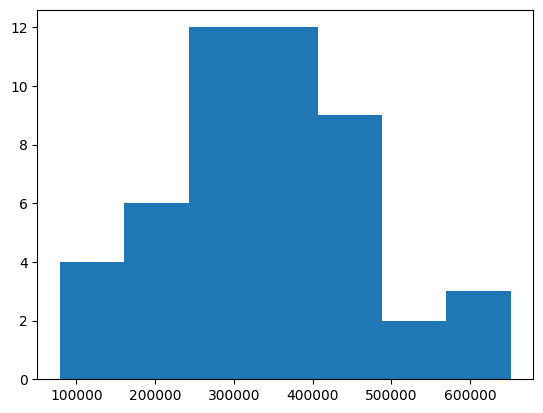

In [43]:
text_num_chars = [len(text) for text in normalised_texts]
plt.hist(text_num_chars, bins=7);
min(text_num_chars), sum(text_num_chars) / len(text_num_chars), max(text_num_chars)

Defining a word using space separation we get close to 5.5 characters per word for all of the texts.

(5.370687955844668, 5.565977554542365, 5.841355854038162)

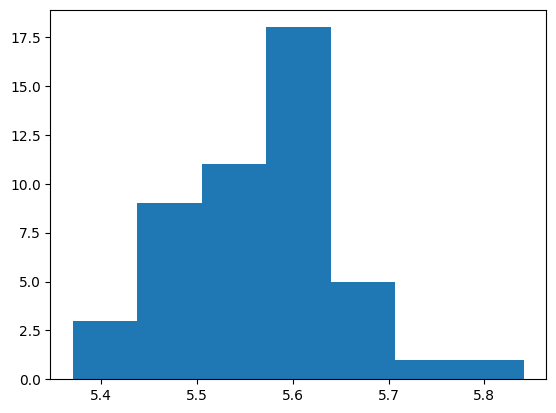

In [44]:
text_chars_per_word = [len(text)/len(text.split()) for text in normalised_texts]
plt.hist(text_chars_per_word, bins=7);
min(text_chars_per_word), sum(text_chars_per_word) / len(text_chars_per_word), max(text_chars_per_word)

# Finding Important Words per Document with TF-IDF

Inspired by Silge and Robinson's [Text Mining with R](https://www.tidytextmining.com/tfidf), we can run a TF-IDF to find the most characteristic words for each text.

First we need to count the words for each text:

In [45]:
word_counts = [Counter(term
                       for term in re.split("[-_(),.?;!:' \"\n]+", text)
                       if term)
               for text in normalised_texts]

Then get the set of all words from the texts:

In [46]:
words = set(word for text_words in word_counts
                 for word in text_words)
len(words)

44424

For each word we calculate the document frequency: the number of documents (books) that contain the word:

In [47]:
df = {word: sum([word in text_words
                 for text_words in word_counts])
      for word in words}

From this we can calculate the Inverse Document Frequncy 

$$ {\rm idf} = \ln\left(\frac{\rm \# documents\ with\ word}{\rm \# documents\ in\ corpus}\right) $$

In [48]:
idf = {word: np.log(len(word_counts)/f) for word, f in df.items()}

And multiply this by the counts to get the TF-IDF for each text:

In [49]:
tfidfs = [{word: tf * idf[word] for word, tf in word_count.items()}
          for word_count in word_counts]

We can then look at the top 10 words by TF-IDF for each text: this tends to pull out the main charactersplaces from the texts (since they are different between texts).

A few common characters stand out between series such as Ukridge, Psmith, and Jeeves.

In [50]:
from IPython.display import display, HTML

n_top_words = 10

html = "<table><tr><th>Title</th>" + \
       "".join([f"<th>{i+1}</th>" for i in range(n_top_words)]) + \
       "</tr>\n"
for idx, tfidf in enumerate(tfidfs):
    title = wodehouse_books[book_ids[idx]]["Title"]
    html += f"<tr><th>{title}</th>"
    for item, score in sorted(tfidf.items(),
                              key=lambda x: x[1],
                              reverse=True)[:n_top_words]:
        html += f"<td>{item}</td>"
    html += "</tr>"
html += "</table>"
HTML(html)

Title,1,2,3,4,5,6,7,8,9,10
Piccadilly Jim,Pett,Crocker,Ann,Wisbeach,Ogden,Jimmy,Bayliss,Trimble,Jerry,Skinner
Something New,Ashe,Peters,Aline,Baxter,Joan,scarab,Emsworth,Freddie,Marson,Honorable
A Damsel in Distress,Marshmoreton,Belpher,Maud,Caroline,Reggie,Plummer,Keggs,Albert,Byng,Billie
"Psmith, Journalist",Psmith,Comrade,Windsor,Billy,Wilberfloss,Maloney,Jarvis,Cosy,Moments,Kid
Indiscretions of Archie,Archie,Lucille,Brewster,McCall,Cosmopolis,Tuyl,Silverton,Connolly,Moffam,Wheeler
Love Among the Chickens,Ukridge,Beale,Garnet,professor,Hawk,Phyllis,Derrick,Garny,Millie,fowls
The Intrusion of Jimmy,Dreever,Jimmy,Spike,McEachern,Molly,Hargate,Pitt,Mifflin,Spennie,lordship
The Little Nugget,Abney,Ogden,Ford,Audrey,Cynthia,MacGinnis,Nugget,Sanstead,Sam,Burns
Uneasy Money,Pickering,Nutty,Claire,Wetherby,Dudley,Dawlish,Elizabeth,Bill,Nichols,Nutcombe
Psmith in the City,Psmith,Bickersdyke,Mike,Comrade,Waller,Rossiter,Jackson,Gregory,Prebble,Bristow


# Split the data

If we want to do some further language modelling on this data we can split it into train, valid and test sets by text.
Note that we're likely to have some characters (like Jeeves, Psmith, and Ukridge) across splits.

We really should split collections of books (like "A Wodehouse Miscellany") separately, but for now we will keep the implementation simple.

In [51]:
import random
from collections import Counter

random.seed("pgwodehouse")

splits = dict(
    train=0.6,
    valid=0.2,
    test=0.2,
)

assert sum(splits.values()) == 1.0

split = random.choices(population=list(splits.keys()),
                       weights=list(splits.values()),
                       k=len(normalised_texts))

Counter(split)

Counter({'train': 30, 'valid': 10, 'test': 8})

To make it easier to work with let's collect the mapping from a split to the list of books it contains.

In [52]:
split2idx = {s: [] for s in splits}
for idx, s in enumerate(split):
    split2idx[s].append(idx)

for s, idxs in split2idx.items():
    for idx in idxs:
        assert split[idx] == s
        
assert sorted(sum([idxs for idxs in split2idx.values()],
                  start=[])) == list(range(len(split)))

{s: len(idxs) for s, idxs in split2idx.items()}

{'train': 30, 'valid': 10, 'test': 8}

We have over 10 million characters of training data (which is around 2 million words); enough for an interesting character level language model.

In [53]:
{s: '{:_}'.format(sum([len(normalised_texts[idx]) for idx in idxs]))
 for s, idxs in split2idx.items()}

{'train': '11_179_271', 'valid': '2_569_961', 'test': '2_736_771'}

# Save the data

## Locally

We can save each normalised text as a text file in a folder corresponding to its split, using the Project Gutenberg id as the filename.
This is saved in a [downloadable zip file](https://github.com/EdwardJRoss/skeptric/raw/master/wodehouse/wodehouse_text.zip)

In [54]:
import shutil
from zipfile import ZipFile

output_dir = Path('output')


if output_dir.exists():
    shutil.rmtree(output_dir)
output_dir.mkdir()

for split, idxs in split2idx.items():
    path = output_dir / split
    path.mkdir()
    for idx in idxs:
        id = book_ids[idx]
        with open(path / (id + ".txt"), "wt") as f:
            f.write(normalised_texts[idx])

shutil.make_archive("wodehouse_text", 'zip', output_dir)


filenames = [f.filename for f in ZipFile("wodehouse_text.zip").filelist
             if not f.is_dir()]
print(fmtcols(filenames, 4, max_len=20, buffer=3))

valid/6985.txt      valid/6955.txt      valid/8178.txt      valid/8931.txt      
valid/6984.txt      valid/6753.txt      valid/65974.txt     valid/3829.txt      
valid/7298.txt      valid/6684.txt      test/6927.txt       test/7230.txt       
test/6980.txt       test/7028.txt       test/2005.txt       test/6768.txt       
test/2042.txt       test/8713.txt       train/8164.txt      train/6836.txt      
train/7050.txt      train/6880.txt      train/6837.txt      train/59254.txt     
train/70041.txt     train/7471.txt      train/72227.txt     train/70222.txt     
train/7464.txt      train/65172.txt     train/8176.txt      train/10554.txt     
train/8190.txt      train/2233.txt      train/60067.txt     train/10586.txt     
train/61507.txt     train/20717.txt     train/6877.txt      train/3756.txt      
train/20532.txt     train/2607.txt      train/4075.txt      train/7423.txt      
train/20533.txt     train/67368.txt     train/6683.txt      train/6879.txt      


## On Huggingface Hub

We can also save the texts, along with their metadata [to Huggingface Hub](https://huggingface.co/datasets/edwardjross/wodehouse).

In [55]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({s: Dataset.from_list([wodehouse_books[book_ids[idx]] | dict(content=normalised_texts[idx]) for idx in split2idx[s]]) for s in split2idx})
ds

DatasetDict({
    train: Dataset({
        features: ['Text#', 'Type', 'Issued', 'Title', 'Language', 'Authors', 'Subjects', 'LoCC', 'Bookshelves', 'raw_text', 'content'],
        num_rows: 30
    })
    valid: Dataset({
        features: ['Text#', 'Type', 'Issued', 'Title', 'Language', 'Authors', 'Subjects', 'LoCC', 'Bookshelves', 'raw_text', 'content'],
        num_rows: 10
    })
    test: Dataset({
        features: ['Text#', 'Type', 'Issued', 'Title', 'Language', 'Authors', 'Subjects', 'LoCC', 'Bookshelves', 'raw_text', 'content'],
        num_rows: 8
    })
})

In [56]:
ds.push_to_hub("edwardjross/wodehouse")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/830 [00:00<?, ?B/s]

# What next?

We've downloaded the P. G. Wodehouse texts from Project Gutenberg and done a rough job of analysing and cleaning them.
While we could do a better job of cleaning them, or obtaining more of them from archive.org, we have done enough to train and test language models on.